#  <span style="color:purple">Projeto - Mineração de texto com stack ELK [22E2_3]</span>

**Erik Tavares dos Anjos** <br />
**Date Updated: 25/06/2022** <br />
**GIT: https://github.com/eriktavares/projeto-minera-o-de-texto-com-stack-ELK**

##  <span style="color:purple">Objetivo</span>

A partir de uma instalação de ES e Kibana, realize as seguintes tarefas: </br>
    1_Escolha um dataset contendo ao menos 1 campo textual. Descreva os campos do seu dataset e seus respectivos tipos de dado. </br>
    2_Elabore um analyzer (pipeline de pré-processamento) de texto para o campo textual. Justifique suas escolhas de tokenizer e token filters. </br>
    3_Crie uma configuração de mapping para o índice que receberá o dataset. Realize a importação de dados para esse índice. </br>
    4_Crie uma busca com agregação sobre os  dados inseridos. </br>
    5_Use a query More Like This para realizar a predição de outro campo do seu dataset, como se fosse um kNN. </br>


##  <span style="color:purple">1. Cenário</span>

O dataset abaixo está disponível no site kaggle pela URL abaixo.

**News Category Dataset </br>
Identify the type of news based on headlines and short descriptions </br>
https://www.kaggle.com/datasets/rmisra/news-category-dataset.** </br>

Context </br>
This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles.

### 1.1 - Leitura do Dataset

O dataset tras 6 colunas 'category', 'headline', 'authors', 'link', 'short_description', 'date'.

**category**: Categória em que a notícia é classificada. </br>
**headline**: Título da Notícia. </br>
**authors**: Autores. </br>
**link**: Link para o site. </br>
**short_description**: Descrição curta, ou um resumo da notícia.</br>
**date**: Data da publicação. </br>

In [426]:
import pandas as pd
df_data = pd.read_json('../Data/archive5zip/News_Category_Dataset_v2.json', orient='records', lines=True)
df_data.head(1).T

,0
category,CRIME
headline,There Were 2 Mass Shootings In Texas Last Week...
authors,Melissa Jeltsen
link,https://www.huffingtonpost.com/entry/texas-ama...
short_description,She left her husband. He killed their children...
date,2018-05-26 00:00:00


### 1.1.1.Categoria

São diversas categórias, como Politica, Bem estar, Enterterimento, Viagens, Stylo e Beleza, e diversas outras. O tipo de dado é um 
keyword, uma palavra chave.

In [427]:
df_data['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

### 1.1.2 Demais Colunas

O **headline** é o título da notícia, abaixo impresso em negrito, e o **short_description** é
a descrição cruta, ambos são textos curtos e que foram um resumo do que será o assunto da notícia. 
Os campos Author, tras o nome do autor da noticia e tem o tipo keywork. A data de publicação está no formato data e o link no formato texto

Abaixo estão alguns exemplos
de notícias (5 primeiras do dataset)

In [428]:
BOLD = '\033[1m'
NORMAL = '\033[0m'

for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Notícia {}:".format(i))
    print(BOLD+df_data['headline'].iloc[i]+'\n'+NORMAL+df_data['short_description'].iloc[i])
    print(df_data['authors'].iloc[i], df_data['date'].iloc[i])
    print(df_data['link'].iloc[i], '\n')

----------------------------------------------------------------
Notícia 0:
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
She left her husband. He killed their children. Just another day in America.
Melissa Jeltsen 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89 

----------------------------------------------------------------
Notícia 1:
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
Of course it has a song.
Andy McDonald 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201 

----------------------------------------------------------------
Notícia 2:
Hugh Grant Marries For The First Time At Age 57
The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
Ron Dicker 2018-05-26 00:00:00
https://www.huffingtonpost.com/entry/hugh-grant-m

##  <span style="color:purple">2. Pré Processamento</span>

Esses dados serão migrados para o banco de dados Elasticsearch 8.2.2. para isso será realizado a analise dos campos para posteriormente realizar a criação do mapeamento.

**Elasticsearch** </br>
o Elasticsearch é um mecanismo de busca e análise de dados distribuído, gratuito e aberto para todos os tipos de dados, incluindo textuais, numéricos, geoespaciais, estruturados e não estruturados. O Elasticsearch é desenvolvido sobre o Apache Lucene e foi lançado pela primeira vez em 2010 pela Elasticsearch N.V. (agora conhecida como Elastic). Conhecido por suas REST APIs simples, natureza distribuída, velocidade e escalabilidade, o Elasticsearch é o componente central do Elastic Stack, um conjunto de ferramentas gratuitas e abertas para ingestão, enriquecimento, armazenamento, análise e visualização de dados. Comumente chamado de ELK Stack (pelas iniciais de Elasticsearch, Logstash e Kibana), o Elastic Stack agora inclui uma rica coleção de agentes lightweight conhecidos como Beats para enviar dados ao Elasticsearch.[https://www.elastic.co/pt/what-is/elasticsearch]

In [429]:
import elasticsearch
import getpass
import urllib3
urllib3.disable_warnings()
senha = getpass.getpass("Digite sua senha: ")

ES_URL = 'https://localhost:9200'
ES_USER = 'elastic'
ES_PASS = senha

client = elasticsearch.Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_PASS),
    verify_certs=False
)
dict(client.info())

Digite sua senha: ········


C:\ProgramData\Anaconda3\lib\site-packages\elasticsearch\_sync\client\__init__.py:395: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


{'name': 'DESKTOP-4SAUDI3',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'HTrqKXa6SSyS9cJuvdjf4A',
 'version': {'number': '8.2.2',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '9876968ef3c745186b94fdabd4483e01499224ef',
  'build_date': '2022-05-25T15:47:06.259735307Z',
  'build_snapshot': False,
  'lucene_version': '9.1.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

### 2.1 Analizer

Text analysis enables Elasticsearch to perform full-text search, where the search returns all relevant results rather than just exact matches [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/analysis-overview.html].

Nesta sessão será realizado a implementação de um analizador para ser aplicado aos campos headline e short_description das noticias.

Para iniciar, será feito o carregamento das stop words em ingles do nltk, essas stop words são palavras que não agregam para resultados de analises de texto.



In [430]:
import nltk
stop_words_en=nltk.corpus.stopwords.words('english')
print(' , '.join([x for x in stop_words_en]))

i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it , it's , its , itself , they , them , their , theirs , themselves , what , which , who , whom , this , that , that'll , these , those , am , is , are , was , were , be , been , being , have , has , had , having , do , does , did , doing , a , an , the , and , but , if , or , because , as , until , while , of , at , by , for , with , about , against , between , into , through , during , before , after , above , below , to , from , up , down , in , out , on , off , over , under , again , further , then , once , here , there , when , where , why , how , all , any , both , each , few , more , most , other , some , such , no , nor , not , only , own , same , so , than , too , very , s , t , can , will , just , don , don't , should , should've , now , d , ll , m , o , re , ve , y , ain , aren , 

**Analizer**
O analiser é o conjunto de char_filter, tokenizer e token filter, de forma simplificada.


**Tokenizer**
Standard tokenizeredit
The standard tokenizer provides grammar based tokenization (based on the Unicode Text Segmentation algorithm, as specified in Unicode Standard Annex #29) and works well for most languages [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/analysis-standard-tokenizer.html].

De forma simplificada, os tokens são separados por espaço, não
há remoção de número ou de apostrofe. Conforme, exemplo abaixo de um texto do dataset.

In [431]:
analyzed = client.indices.analyze(
        tokenizer="standard",
        text="Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song"
)
print([x["token"] for x in analyzed['tokens']])

['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']


Para remorada dos números será utilizado Char filter.

**Char filter**
Os filtros de caracteres são usados ​​para pré-processar o fluxo de caracteres antes que ele seja passado para o tokenizador. No analisardor desenvolvido, possui um char_filter para remoção de números, como são textos de noticias, são é necessário que os números virem tokens.

**Token filter**
Os token filter ja modificam os tokens após o tokenizer. Para o analizador, será utilizado token filter "lowercase", "asciifolding", "apostrophe" e "stop_custom". O lowercase para passar as letras para minusculas dos tokens. O asciifolding remove acentos e caracteres especiais. O Apostrophe é para remoção de apostrophe dos tokens, como em [cup's] --> [cup]. Por ultimo, o custom stop words para utilização das stop words do nltk. 

In [432]:
INDICE_NAME = 'category_index'


analysis={
          "analyzer": {
            "analizer_text": { 
                  "char_filter": [
                    "replace_numbers"
                    ],
                  "tokenizer": "standard",
                  "filter": [
                      "lowercase",
                      "asciifolding",
                      "apostrophe",
                      "stop_custom",
                  ]
                }
              },
          "char_filter": {
             "replace_numbers": {
                    "type": "pattern_replace",
                    "pattern": "([0-9]+)",
                    "replacement": ""
             },
          },
          "filter": {
            "english_stop": { 
              "type": "stop",
              "stopwords": "_english_"
            },
            "stop_custom": {
                "type": "stop",
                "stopwords": stop_words_en,
        },
    }
}

text_category_analizer = {   
    "settings": {
        "analysis": analysis
      }
    }
    
if client.indices.exists(index=INDICE_NAME):
    client.indices.delete(index=INDICE_NAME)
client.indices.create(index=INDICE_NAME, **text_category_analizer)



ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'category_index'})

O resultado do analizador pode ser visto em alguns textos do dataset (5 primeiros), Linha em negrito com headline e embaixo,
após uma lista de tokens após o analizer. Na linha normal, logo abaixo, o short description e uma lista com os tokens resultantes.

In [433]:
for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Noticia",i)
    resp_title = client.indices.analyze(
        index="category_index",
        analyzer="analizer_text",
        text=df_data['headline'].iloc[i],
    )
    resp_desc = client.indices.analyze(
        index="category_index",
        analyzer="analizer_text",
        text=df_data['short_description'].iloc[i],
    )
    print(BOLD+df_data['headline'].iloc[i])
    print('[', BOLD+' , '.join([x["token"] for x in resp_title['tokens']]),']\n')
    
    print(NORMAL+df_data['short_description'].iloc[i])
    print(NORMAL+'[',' , '.join([x["token"] for x in resp_desc['tokens']]),"]")

    #print(df_data['authors'].iloc[i], df_data['date'].iloc[i])
    #print(df_data['link'].iloc[i], '\n')

----------------------------------------------------------------
Noticia 0
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
[ mass , shootings , texas , last , week , tv ]

She left her husband. He killed their children. Just another day in America.
[ left , husband , killed , children , another , day , america ]
----------------------------------------------------------------
Noticia 1
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
[ smith , joins , diplo , nicky , jam , world , cup , official , song ]

Of course it has a song.
[ course , song ]
----------------------------------------------------------------
Noticia 2
Hugh Grant Marries For The First Time At Age 57
[ hugh , grant , marries , first , time , age ]

The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
[ actor , longtime , girlfriend , anna , eberstein , tied , knot , civil , ceremony ]
--------------------------------------------------------

##  <span style="color:purple">3. Mapping e insert</span>

### 3.1 Mapeando os campos

Os campos do dataset serão mapeados para posteriormente serem inseridos no elastichsearch, 

**Category** Campo que descreve o assunto da noticia, será mapeado com um campo extra do tipo keyword para permitir a busca com nome exato. E para o texto, o analiser desenvolvido acima, para garantir que os tokens para as categorias com as regras descritas cima.

**headline** Campo com titulo da nóticia, tipo text, e com analiser devolvido acima.

**short_description** Campo com um resumo da nótica ou um subtitulo, tipo text, e com analiser devolvido acima.

**authors** Campo texto com o nome do autor, analisador padrão do elastic e keyword para busca com nome exato.

**Link** Link tipo texto

**Data** Data tipo data

In [434]:

INDEX_NAME = 'news_category_detection'

INDEX_MAPPING = {
        "settings": {
            "number_of_shards": 3,
            "analysis": analysis
    },
    "mappings": {
        "properties": {
            "category": {
                "type": "text",
                "analyzer": "analizer_text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "headline": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                    },
            },
            "short_description": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            },
            "authors": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "link": {
                "type": "text"
                
            },
            "date": {
                "type": "date"
            },
        }
    }
}

if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection'})

A inserção dos documentos será feit através da tenica bulk

### 3.2 Inserindo os documentos

In [435]:
from elasticsearch.helpers import bulk

def gen_documents(df):
    for line in df.index:
         yield df.iloc[line].to_dict()
            
def gen_index_actions(documents):
    for doc in documents:
        yield {
            '_op_type': 'index',
            '_index': INDEX_NAME,
            **doc,
        }
        

In [436]:
      
if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection'})

In [437]:
%%time
documents = gen_documents(df_data)
actions = gen_index_actions(documents)

success, errors = bulk(client, actions)

client.indices.refresh(index=INDEX_NAME)
client.indices.flush(index=INDEX_NAME)

Wall time: 1min 1s


ObjectApiResponse({'_shards': {'total': 6, 'successful': 3, 'failed': 0}})

##  <span style="color:purple">4. Buscas e Agregações</span>

Com os documentos inseridos é possível então realizar buscar os dados e obter seus resultados. Por exemplo,
quem são os autores com maior número de notícias, ou os autores com maior número de notícas.


### 4.1 Busa pelo campo Autores

In [440]:
QUERY = {
    'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'authors.raw',
            'size': 40,
        }
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

In [441]:
df_authors_agg = pd.DataFrame(resp['aggregations']['grupos']['buckets'])
df_authors_agg

,key,doc_count
0,,36620
1,Lee Moran,2423
2,Ron Dicker,1913
3,"Reuters, Reuters",1562
4,Ed Mazza,1322
5,Cole Delbyck,1140
6,Andy McDonald,1068
7,Julia Brucculieri,1059
8,Carly Ledbetter,1054
9,Curtis M. Wong,1020


### 4.2 Busca pela Categória Politica

Palavras mais comentadas nos títulos na categoria de Política

In [442]:
QUERY = {
    'term': {
        'category.raw': 'POLITICS'
    }
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'headline',
            'size': 100,
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
df_politcs_agg_headline = pd.DataFrame(resp['aggregations']['grupos']['buckets'])
df_politcs_agg_headline

,key,doc_count
0,trump,8865
1,donald,2953
2,clinton,1468
3,obama,1422
4,gop,1397
...,...,...
95,orlando,32
96,top,32
97,love,30
98,convention,29


Uma wordcloud das palavras da categória de Política

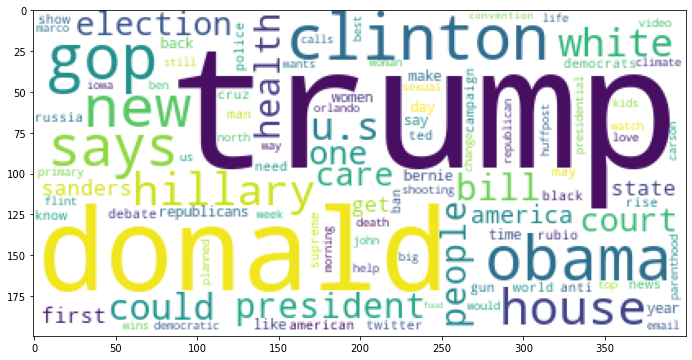

In [443]:
import wordcloud
import matplotlib.pyplot as plt
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

### 4.3 Busca Geral

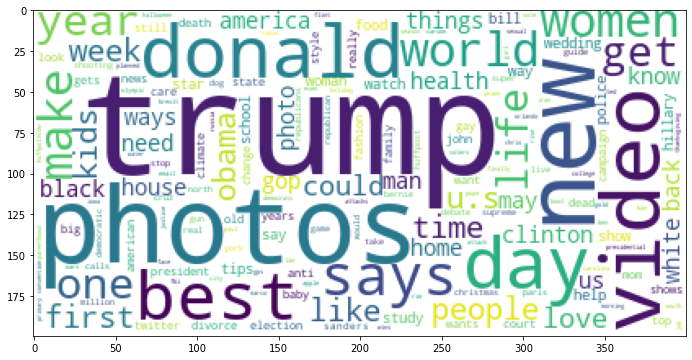

In [444]:
QUERY = {
     'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'headline',
            'size': 2000000
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

##  <span style="color:purple">4. More Like This</span>

The More Like This Query finds documents that are "like" a given set of documents. In order to do so, MLT selects a set of representative terms of these input documents, forms a query using these terms, executes the query and returns the results. The user controls the input documents, how the terms should be selected and how the query is formed [https://www.elastic.co/guide/en/elasticsearch/reference/8.2/query-dsl-mlt-query.html].

Pode ser utilizada por exemplo para encontrar informações aproximadas, por exemplo, a busca por "president"

In [445]:
QUERY = {
    'more_like_this': {
        'fields': ['headline', 'short_description'],
        'like':"president",
        'min_term_freq': 1,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)
df_resp = pd.DataFrame(x['_source'] for x in resp['hits']['hits'])
df_resp

,category,headline,authors,link,short_description,date
0,POLITICS,Not Even Donald Trump Can Believe He's President,Igor Bobic,https://www.huffingtonpost.com/entry/donald-tr...,"""I’m president ― hey, I’m president!""",2017-05-04T00:00:00
1,POLITICS,Wednesday's Morning Email: Why Obama May Be Kn...,Lauren Weber,https://www.huffingtonpost.com/entry/wednesday...,"The president has commuted 1,385 sentences, th...",2017-01-18T00:00:00
2,POLITICS,Emmanuel Macron Dropped Onto A Nuclear Sub And...,Lee Moran,https://www.huffingtonpost.com/entry/emmanuel-...,"""Now that's a President!""",2017-07-06T00:00:00
3,POLITICS,How Obama's 'Brutal' First Job Inspired A New ...,Chris D'Angelo,https://www.huffingtonpost.com/entry/obama-fir...,Before Obama was president of the United State...,2016-02-28T00:00:00
4,COMEDY,Stephen Colbert Just Wants Donald Trump's Lawy...,Ron Dicker,https://www.huffingtonpost.com/entry/stephen-c...,"He calls Jay Sekulow ""the President Trump of t...",2017-06-20T00:00:00
5,POLITICS,Nancy Pelosi Calls For Sean Spicer's Ouster Am...,Igor Bobic,https://www.huffingtonpost.com/entry/nancy-pel...,"""Either he is speaking for the president, or t...",2017-04-11T00:00:00
6,POLITICS,Not Even Mike Pence Can Defend Trump's Wiretap...,Sam Levine,https://www.huffingtonpost.com/entry/mike-penc...,“I think the president’s tweet speaks for itse...,2017-03-07T00:00:00
7,POLITICS,Obama Urges Russia To Stop Bombing 'Moderate' ...,,https://www.huffingtonpost.com/entry/obama-rus...,The president spoke with Russian President Vla...,2016-02-14T00:00:00
8,COMEDY,John Oliver Announces His Endorsements For Thi...,Lee Moran,https://www.huffingtonpost.com/entry/john-oliv...,"""But not for president of course.""",2016-07-18T00:00:00
9,POLITICS,Tuesday's Morning Email: Everything You Need T...,Lauren Weber,https://www.huffingtonpost.com/entry/tuesdays-...,And what it means for President,2017-03-21T00:00:00


In [446]:
df_resp.iloc[0].T

category                                                      POLITICS
headline              Not Even Donald Trump Can Believe He's President
authors                                                     Igor Bobic
link                 https://www.huffingtonpost.com/entry/donald-tr...
short_description                "I’m president ― hey, I’m president!"
date                                               2017-05-04T00:00:00
Name: 0, dtype: object

In [447]:
df_resp ['headline'].iloc[0]

"Not Even Donald Trump Can Believe He's President"

### Classificador KNN com More like this

Os metodos abaixo criam o classificador da seguinte forma, inicialmente seleciona uma quantidade de documentos.
Para utilizar o more like this para obter uma quantidade de documentos visinhos e 
classificar com base na categória do documento selecionado, com base na categória com maior score dos vizinhos.

**Implementando Classificador**

Seleciona um documento, por exemplo:

In [517]:
test_docs_resp = client.search(index=INDEX_NAME, size=1)
test_docs_resp['hits']

{'total': {'value': 10000, 'relation': 'gte'},
 'max_score': 1.0,
 'hits': [{'_index': 'news_category_detection',
   '_id': 'rdJ-m4EBE8fvlEs2Vm-w',
   '_score': 1.0,
   '_source': {'category': 'THE WORLDPOST',
    'headline': 'British Mosques Open Doors For Tea And Interfaith Engagement',
    'authors': 'Carol Kuruvilla',
    'link': 'https://www.huffingtonpost.com/entry/visit-my-mosque-day_us_5898aaace4b0406131381022',
    'short_description': 'In a climate of rising anti-Muslim rhetoric, the U.K. held its biggest "Visit My Mosque" day yet.',
    'date': '2017-02-06T00:00:00'}}]}

Cria um dataframe para os documentos de teste

In [518]:
test_docs = pd.DataFrame(
        {
            '_id': x['_id'],
            **x['_source']
        } for x in test_docs_resp['hits']['hits']
    )
test_docs['category'].value_counts()

THE WORLDPOST    1
Name: category, dtype: int64

Aplica a query Mode Like This para selecionar os 10 mais próximos deste documento.

In [521]:
QUERY = {
    'more_like_this': {
        'fields': ["headline"],
        'like': [
            {
                '_index': INDEX_NAME,
                '_id': 'rdJ-m4EBE8fvlEs2Vm-w',
            }
        ],
        'min_term_freq': 1,
        'max_query_terms': 12,
        'minimum_should_match': -100,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)
resp_df = pd.DataFrame({'_id': x['_id'], '_score': x['_score'], **x['_source']} for x in resp['hits']['hits'])
resp_df.groupby('category').sum()

,_score
category,
BUSINESS,12.120592
COLLEGE,12.814263
COMEDY,28.096938
POLITICS,12.132198
RELIGION,30.615908
SPORTS,25.283963
WELLNESS,14.264799


Ordena a lista para que a categória com maior Score fique primeiro

In [522]:
resp_df.groupby('category').sum().sort_values('_score', ascending=False)

,_score
category,
RELIGION,30.615908
COMEDY,28.096938
SPORTS,25.283963
WELLNESS,14.264799
COLLEGE,12.814263
POLITICS,12.132198
BUSINESS,12.120592


Retorna a categória com maior Score

In [524]:
resp_df.groupby('category').sum().sort_values('_score', ascending=False).iloc[0]

_score    30.615908
Name: RELIGION, dtype: float64

**Avaliando com mais documentos**

Metodo para realização dessa classificação para um conjunto de documentos. Para este dataset foi observado que diversas vezes ele não
encontra nenhum documento, então 'minimum_should_match': -100 foi ajustado para ampliar os match com os documentos e evitar erro quando
    o metodo não retorna nada. E também foi criada uma busca alternativa para caso não retornar nada. Porme mesmo com diversos tipos de buscar como 'fields': ["headline^2","short_description"]  e outras tentativas, ainda sim ocorre de não ter nenhum match na consulta like, para este dataset.

In [529]:
def classify_document(doc_id, size=10):
    return classify_with_score(
        [
            {
                '_index': INDEX_NAME,
                '_id': doc_id
            }
        ]
    )

def nova_busca(like, size=10):
    query = {
        'more_like_this': {
            'fields': ["short_description"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
            'minimum_should_match': -100,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    return formata_retorno(resp)
    
    
def formata_retorno(resp):
    resp_df = pd.DataFrame(
                {
                    '_id': x['_id'],
                    '_score': x['_score'],
                    **x['_source']
                } for x in resp['hits']['hits']
            )
    return resp_df.groupby('category').sum().sort_values('_score', ascending=False).index[0]


def classify_with_score(like, size=10):
    
    query = {
        'more_like_this': {
            'fields': ["headline"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
            'minimum_should_match': -100,
        }
    }
    
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    if(resp['hits']['total']['value']<0):
        return formata_retorno(resp)
    else:
        return nova_busca(like)
    
    
def resp_to_dataFrame(resp):
    test_docs = pd.DataFrame(
        {
            '_id': x['_id'],
            **x['_source']
        } for x in test_docs_resp['hits']['hits']
    )
    return test_docs

In [532]:
test_docs_resp = client.search(index=INDEX_NAME, size=50)
test_docs=resp_to_dataFrame(resp)

Aplica o metodo para classify_document que chama o metodo classify_with_score que executa o uma consulta more like this passando o
id do documento no like. No metodo vai executar a consulta passando um id, receber os 10 vizinhos mais proximos, criar um dataframe com o resultado e agrupar pelas categorias somando os scores. 

In [533]:
test_docs['predicted'] = test_docs['_id'].apply(classify_document)

Um pequeno ajuste precisou ser feito no metodo, primeiro, ordenar a o dataframe pelo score, para que o registro com maior score fique primeiro.
E posteriomente retornar a categoria com maior score.

Com as classification_report calcular as metricas de resultados. Os resultados não foram bons, o dataframe possui muitas catgorias e as informações textuais são curtas para se definir.

Os resultados obtivos com a classificação foram muito baixos, mas porque o dataset possui muito categórias, que são muito semelhantes até
como por exemplo: WORLD NEWS, THE WORLDPOST e WORLDPOST. Outro caso são buscas onde a consulta like não retorna nenhum documento.

In [534]:
from sklearn.metrics import classification_report
print(
    classification_report(
        test_docs['category'],
        test_docs['predicted']
    )
)

                precision    recall  f1-score   support

  BLACK VOICES       1.00      0.50      0.67         2
      BUSINESS       0.00      0.00      0.00         1
        COMEDY       0.00      0.00      0.00         2
         CRIME       1.00      1.00      1.00         1
 ENTERTAINMENT       0.33      0.43      0.38         7
     GOOD NEWS       0.00      0.00      0.00         0
         GREEN       0.00      0.00      0.00         1
HEALTHY LIVING       0.00      0.00      0.00         1
 LATINO VOICES       0.00      0.00      0.00         1
         MEDIA       0.00      0.00      0.00         1
     PARENTING       0.00      0.00      0.00         0
       PARENTS       0.00      0.00      0.00         1
      POLITICS       0.46      0.73      0.56        15
  QUEER VOICES       0.00      0.00      0.00         4
      RELIGION       0.00      0.00      0.00         3
       SCIENCE       0.00      0.00      0.00         0
        SPORTS       0.25      0.33      0.29  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

### 4.2 Outro Dataset

Na avaliação do classificador feita acima, foi observado que os resultados não de f1 e acurácia não foram satisfatorios. Para ter certeza
se o problema é o classificador ou o dataset, podemos realizar um teste com outro dataset com numero bem menor de categórias para as noticias.

In [535]:
import pandas as pd
df2_data = pd.read_csv('../Data/archive6/bbc-news-data.csv', sep='\t')
df2_data.head(1).T

,0
category,business
filename,001.txt
title,Ad sales boost Time Warner profit
content,Quarterly profits at US media giant TimeWarne...


Esse dataset possui 5 categórias conforme mostrado abaixo:

In [536]:
df2_data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [537]:
BOLD = '\033[1m'
NORMAL = '\033[0m'

for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Notícia {}:".format(i))
    print(BOLD+df2_data['title'].iloc[i]+'\n'+NORMAL+df2_data['content'].iloc[i])
    print(df2_data['category'].iloc[i])

----------------------------------------------------------------
Notícia 0:
Ad sales boost Time Warner profit
 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the onli

**Analiser**

Será aproveitado o mesmo analiser feito acima para o 1° dataset.

In [540]:

for i in range(0,5):
    print("----------------------------------------------------------------")
    print("Noticia",i)
    resp_title = client.indices.analyze(
        index=INDICE_NAME,
        analyzer="analizer_text",
        text=df2_data['title'].iloc[i],
    )
    resp_desc = client.indices.analyze(
        index=INDICE_NAME,
        analyzer="analizer_text",
        text=df2_data['content'].iloc[i],
    )
    print(BOLD+df2_data['title'].iloc[i])
    print('[', BOLD+' , '.join([x["token"] for x in resp_title['tokens']]),']\n')
    
    print(NORMAL+df2_data['content'].iloc[i], '\n')
    print(NORMAL+'[',' , '.join([x["token"] for x in resp_desc['tokens']]),"]")

    #print(df_data['authors'].iloc[i], df_data['date'].iloc[i])
    #print(df_data['link'].iloc[i], '\n')

----------------------------------------------------------------
Noticia 0
Ad sales boost Time Warner profit
[ ad , sales , boost , time , warner , profit ]

 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It ho

**Mapeamento**

In [553]:
INDEX_NAME = 'news_category_detection_data_2'

INDEX_MAPPING = {
        "settings": {
            "number_of_shards": 3,
            "analysis": analysis
    },
    "mappings": {
        "properties": {
            "category": {
                "type": "text",
                "analyzer": "analizer_text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "title": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                    },
            },
            "content": {
                "type": "text",
                "analyzer": "analizer_text",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            },
            "filename": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
        }
    }
}

if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection_data_2'})

**Insersão dos dados no elastich**

In [554]:
%%time
documents = gen_documents(df2_data)
actions = gen_index_actions(documents)

success, errors = bulk(client, actions)

client.indices.refresh(index=INDEX_NAME)
client.indices.flush(index=INDEX_NAME)

Wall time: 1.6 s


ObjectApiResponse({'_shards': {'total': 6, 'successful': 3, 'failed': 0}})

**Nuvem de palavras**

Palavras como UK (united Kingdon) e US (United States), new (pode ser inserida na lista de stop words, por ventura), blair e film
estão entre as que mais aparecem no titulo.

{'total': {'value': 2225, 'relation': 'eq'}, 'max_score': None, 'hits': []}

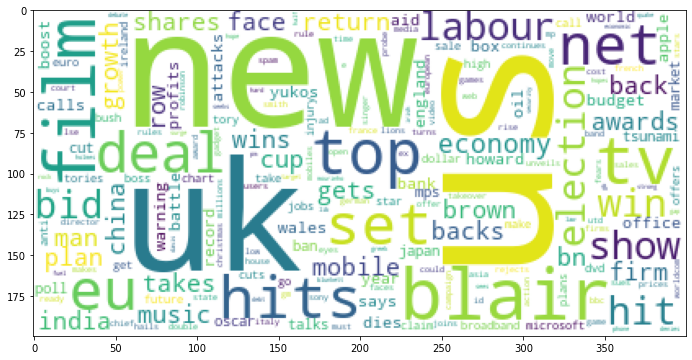

In [556]:
INDEX_NAME = 'news_category_detection_data_2'
QUERY = {
     'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'title',
            'size': 22000
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)
resp['hits']

Nuvem de palavras do texto

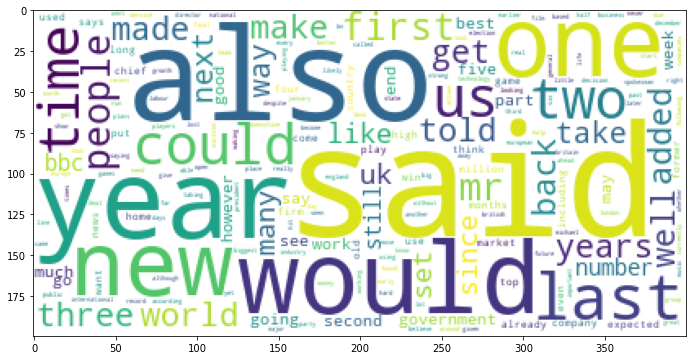

In [557]:
QUERY = {
     'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'content',
            'size': 2000000
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

In [559]:
Classificador para o Dataset novo.

SyntaxError: invalid syntax (Temp/ipykernel_20388/4031211841.py, line 1)

In [560]:
def classify_document2(doc_id, size=10):
    return classify_with_score2(
        [
            {
                '_index': INDEX_NAME,
                '_id': doc_id
            }
        ]
    )

def classify_with_score2(like, size=10):
    
    query = {
        'more_like_this': {
            'fields': ["content"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
            'minimum_should_match': -100,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    resp_df = pd.DataFrame(
            {
                '_id': x['_id'],
                '_score': x['_score'],
                **x['_source']
            } for x in resp['hits']['hits']
        )

    
    return resp_df.groupby('category').sum().sort_values('_score', ascending=False).index[0]
    

**Avaliação do Classificador**

In [561]:
test_docs_resp = client.search(index=INDEX_NAME, size=1000, _source=['category'])
test_docs = pd.DataFrame({'_id': x['_id'],**x['_source']} for x in test_docs_resp['hits']['hits'])
test_docs['predicted'] = test_docs['_id'].apply(classify_document2)
print(classification_report(test_docs['category'], test_docs['predicted']))

               precision    recall  f1-score   support

     business       0.98      0.93      0.96       326
entertainment       0.99      0.94      0.96       211
     politics       0.89      0.97      0.93       158
        sport       0.97      0.99      0.98       177
         tech       0.91      0.98      0.94       128

     accuracy                           0.96      1000
    macro avg       0.95      0.96      0.95      1000
 weighted avg       0.96      0.96      0.96      1000



Acurácia de 94%, resultado muito bom para a definição nesses 5 temas através dos 10 vizinhos mais póximos. Esse segundo dataset
acaba sendo melhor para se classificar dessa forma, por que possui o campo content que tem textos mais longos, e menos categórias 
do que o primeiro.

In [562]:
test_docs_resp = client.search(index=INDEX_NAME, size=2225, _source=['category'])
test_docs = pd.DataFrame({'_id': x['_id'],**x['_source']} for x in test_docs_resp['hits']['hits'])
test_docs['predicted'] = test_docs['_id'].apply(classify_document2)
print(classification_report(test_docs['category'], test_docs['predicted']))

               precision    recall  f1-score   support

     business       0.95      0.91      0.93       510
entertainment       0.96      0.92      0.94       386
     politics       0.93      0.95      0.94       417
        sport       0.98      0.99      0.98       511
         tech       0.91      0.96      0.93       401

     accuracy                           0.95      2225
    macro avg       0.95      0.95      0.95      2225
 weighted avg       0.95      0.95      0.95      2225



Incluindo mais algumas stop_words, como 'said', 'also', 'one', 'two', 'would' que podem não agregar no processo de classificação da categoria da noticia.

In [567]:
INDICE_NAME = 'category_index2'


analysis={
          "analyzer": {
            "analizer_text2": { 
                  "char_filter": [
                    "replace_numbers"
                    ],
                  "tokenizer": "standard",
                  "filter": [
                      "lowercase",
                      "asciifolding",
                      "apostrophe",
                      "stop_custom",
                  ]
                }
              },
          "char_filter": {
             "replace_numbers": {
                    "type": "pattern_replace",
                    "pattern": "([0-9]+)",
                    "replacement": ""
             },
          },
          "filter": {
            "english_stop": { 
              "type": "stop",
              "stopwords": "_english_"
            },
            "stop_custom": {
                "type": "stop",
                "stopwords": stop_words_en + ['said', 'also', 'one', 'two', 'would']
        },
    }
}

text_category_analizer = {   
    "settings": {
        "analysis": analysis
      }
    }
    
if client.indices.exists(index=INDICE_NAME):
    client.indices.delete(index=INDICE_NAME)
client.indices.create(index=INDICE_NAME, **text_category_analizer)




INDEX_NAME = 'news_category_detection_data_2'

INDEX_MAPPING = {
        "settings": {
            "number_of_shards": 3,
            "analysis": analysis
    },
    "mappings": {
        "properties": {
            "category": {
                "type": "text",
                "analyzer": "analizer_text2",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "title": {
                "type": "text",
                "analyzer": "analizer_text2",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                    },
            },
            "content": {
                "type": "text",
                "analyzer": "analizer_text2",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            },
            "filename": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
        }
    }
}

if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'news_category_detection_data_2'})

In [568]:
%%time
documents = gen_documents(df2_data)
actions = gen_index_actions(documents)

success, errors = bulk(client, actions)

client.indices.refresh(index=INDEX_NAME)
client.indices.flush(index=INDEX_NAME)

Wall time: 1.21 s


ObjectApiResponse({'_shards': {'total': 6, 'successful': 3, 'failed': 0}})

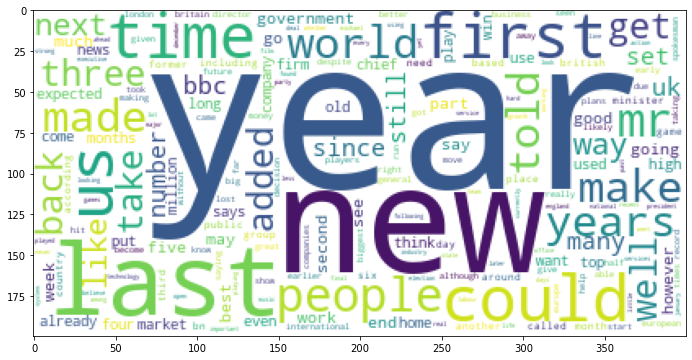

In [569]:
QUERY = {
     'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'content',
            'size': 2000000
        },
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
frequencies = {}
buckets =resp['aggregations']['grupos']['buckets']
for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

In [570]:
test_docs_resp = client.search(index=INDEX_NAME, size=2225, _source=['category'])
test_docs = pd.DataFrame({'_id': x['_id'],**x['_source']} for x in test_docs_resp['hits']['hits'])
test_docs['predicted'] = test_docs['_id'].apply(classify_document2)
print(classification_report(test_docs['category'], test_docs['predicted']))

               precision    recall  f1-score   support

     business       0.96      0.92      0.93       510
entertainment       0.96      0.92      0.94       386
     politics       0.93      0.94      0.93       417
        sport       0.97      0.99      0.98       511
         tech       0.91      0.96      0.93       401

     accuracy                           0.95      2225
    macro avg       0.95      0.95      0.95      2225
 weighted avg       0.95      0.95      0.95      2225



In [ ]:
Outro formato de consulta, com título e content 

In [571]:
def classify_document3(doc_id, size=10):
    return classify_with_score3(
        [
            {
                '_index': INDEX_NAME,
                '_id': doc_id
            }
        ]
    )

def classify_with_score3(like, size=10):
    
    query = {
        'more_like_this': {
            'fields': ["title", "content"],
            'like':like,
            'min_term_freq': 1,
            'max_query_terms': 12,
            'minimum_should_match': -100,
        }
    }
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    resp_df = pd.DataFrame(
            {
                '_id': x['_id'],
                '_score': x['_score'],
                **x['_source']
            } for x in resp['hits']['hits']
        )

    
    return resp_df.groupby('category').sum().sort_values('_score', ascending=False).index[0]
    

In [572]:
test_docs_resp = client.search(index=INDEX_NAME, size=2225)
test_docs = pd.DataFrame({'_id': x['_id'],**x['_source']} for x in test_docs_resp['hits']['hits'])
test_docs['predicted'] = test_docs['_id'].apply(classify_document3)
print(classification_report(test_docs['category'], test_docs['predicted']))

               precision    recall  f1-score   support

     business       0.95      0.92      0.93       510
entertainment       0.96      0.92      0.94       386
     politics       0.92      0.94      0.93       417
        sport       0.97      0.99      0.98       511
         tech       0.91      0.96      0.93       401

     accuracy                           0.95      2225
    macro avg       0.94      0.94      0.94      2225
 weighted avg       0.95      0.95      0.95      2225



Textos onde o classificador errou na predição, textos originais, sem analizador. Pode ser feito uma analise textual onde o o classificar não acertou para possível melhoria, ou quem sabe ser revisto a classificação do tópico.

In [575]:
for line in test_docs.index:
    if(test_docs['category'].iloc[line]!=test_docs['predicted'].iloc[line]):
        print(BOLD+"Predito:",test_docs['predicted'].iloc[line])
        print(BOLD+"Real:",test_docs['category'].iloc[line])
        print("------------------------------------------------")
        print(NORMAL+test_docs['content'].iloc[line])


Predito: tech
Real: business
------------------------------------------------
 The European Commission has written to the mobile phone operators Vodafone and T-Mobile to challenge "the high rates" they charge for international roaming.  In letters sent to the two companies, the Commission alleged the firms were abusing their dominant market position in the German mobile phone market. It is the second time Vodafone has come under the Commission's scrutiny. The UK operator is already appealing against allegations that its UK roaming rates are "unfair and excessive". Vodafone's response to the Commission's letter was defiant. "We believe the roaming market is competitive and we expect to resist the charges," said a Vodafone spokesman. "However we will need time to examine the statement of objections in detail before we formally respond."  The Commission's investigation into Vodafone and Deutsche Telekom's T-Mobile centres on the tariffs the two companies charge foreign mobile operators to

O primeiro dataset tem pouca informação textual para esse tipo de classificação, então diversos problemas foram verificados, como
o retorno sem match de nenhum documento e a dificuldade em se classificar, que também pode ser vista pelo número alto ed categórias. 
O segundo data set tem mais texto e possui menos categórias, então o classificador tem alta taxa de acerto dos assuntos.